In [85]:
#Autor: Gustavo Alejandro Gutiérrez Valdes
import numpy as np # type: ignore
import pandas as pd # type: ignore
import statsmodels.api as sm # type: ignore
import seaborn as sns # type: ignore
import matplotlib.pyplot as plt # type: ignore
import statsmodels.formula.api as smf # type: ignore


### Data set "Animals"

[Animals dataset](https://stat.ethz.ch/R-manual/R-patched/library/MASS/html/Animals.html)

Average brain and body weights for 28 species of land animals.

In [86]:
url = 'https://drive.google.com/file/d/1wfUUKU2VbmK-WzehMKft8u1WMEfyOXTy/view?usp=sharing'
file_id = url.split('/')[-2]
dwn_url = 'https://drive.google.com/uc?id=' + file_id

In [87]:
data = pd.read_csv(dwn_url, header=0, index_col=0)

- We want to use a linear model to study the relation between the brain weight and the body weight

- Simple linear regression (one predictor):

$brain=\beta_0+\beta_1*body+\varepsilon$


### Regression assumption on Y

- Our model: $Y=\beta_0+\beta_1*x+\varepsilon$

- Given that we assume the errors $\varepsilon$ to have normal distribution $\mathcal{N}(0,\sigma^2)$, we assume that also $Y$ are normally distributed.

- Check the assumption on $Y$

- If the response variable is not gaussian, a linear model should not be used.



### Transformations

Apply the necessary transformations to Y and X, use log transformation.

In [88]:
#Apply the necessary transformations to the data
data['log_brain'] = np.log(data['brain'])
data['log_body'] = np.log(data['body'])


### Outliers

Detect the outliers using boxplots, histograms or scatter plots. Findout which are the animals corresponding to the outliers.

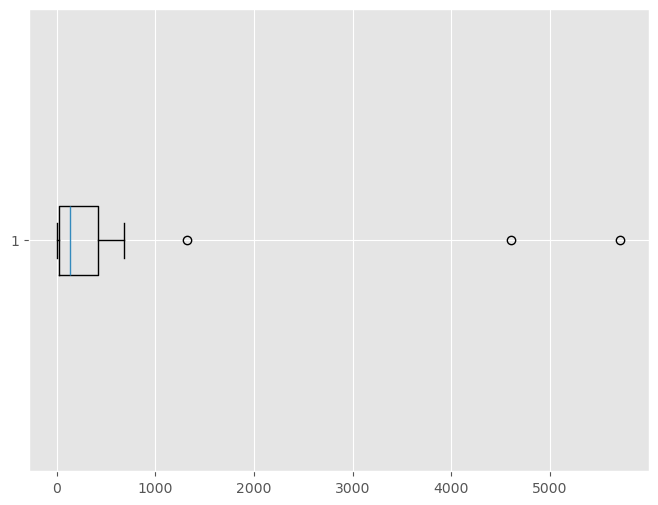

In [89]:
#Detect the outliers using boxplot
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(8, 6))
ax.boxplot(data[['brain']], vert=False)
plt.show()



In [90]:
def detect_outliers(df):
    outliers = {}
    for column in df.columns:
        # Calcular Q1 (primer cuartil) y Q3 (tercer cuartil)
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        # Definir los límites para los outliers
        lower_bound = Q1 - 15.5 * IQR
        upper_bound = Q3 + 15.5 * IQR
        # Identificar outliers
        outliers[column] = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
        # Imprimir outliers para cada columna
        print(outliers[column])
    return outliers

# Obtener outliers
outliers = detect_outliers(data)

                  body  brain  log_brain   log_body
Dipliodocus    11700.0   50.0   3.912023   9.367344
Triceratops     9400.0   70.0   4.248495   9.148465
Brachiosaurus  87000.0  154.5   5.040194  11.373663
Empty DataFrame
Columns: [body, brain, log_brain, log_body]
Index: []
Empty DataFrame
Columns: [body, brain, log_brain, log_body]
Index: []
Empty DataFrame
Columns: [body, brain, log_brain, log_body]
Index: []


### Annotations:
The outliers are 3: Dipliodocus, Triceratops, Brachiosaurus. They are all dinosaurs, and the only dinosaurs in the dataset

## Linear regression 1

Apply a simple linear regression using the model:

$\log(brain)=\beta_0+\beta_1*log(body)+\varepsilon $

In [91]:
xc = sm.add_constant(data['log_body'])
model1_simpleLinearRegression = sm.OLS(data['log_brain'], xc)

model1_results = model1_simpleLinearRegression.fit()
print(model1_results.summary())

                            OLS Regression Results                            
Dep. Variable:              log_brain   R-squared:                       0.608
Model:                            OLS   Adj. R-squared:                  0.593
Method:                 Least Squares   F-statistic:                     40.26
Date:                Fri, 30 Aug 2024   Prob (F-statistic):           1.02e-06
Time:                        19:32:18   Log-Likelihood:                -50.629
No. Observations:                  28   AIC:                             105.3
Df Residuals:                      26   BIC:                             107.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.5549      0.413      6.184      0.0

In [92]:
model1_results.params

const       2.554898
log_body    0.495995
dtype: float64

Denoting with $Y_i$ the observations and with $\hat{Y_i}$ the estimations, the residuals are:

$residuals=|Y_i-\hat{Y_i}|$


Draw an histogram of the residuals and a scatter plot of residuals vs fittedvalues. Do the plots suggest a proper residual behavior?

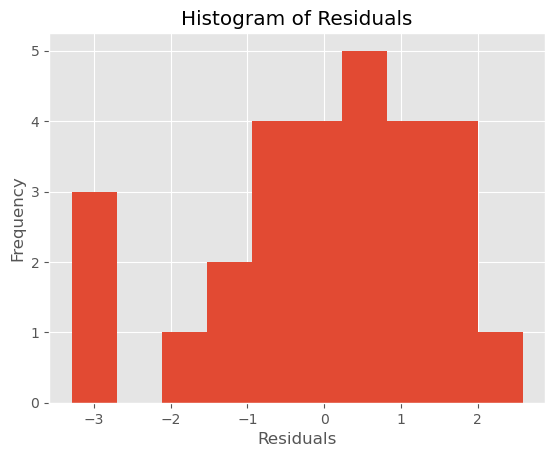

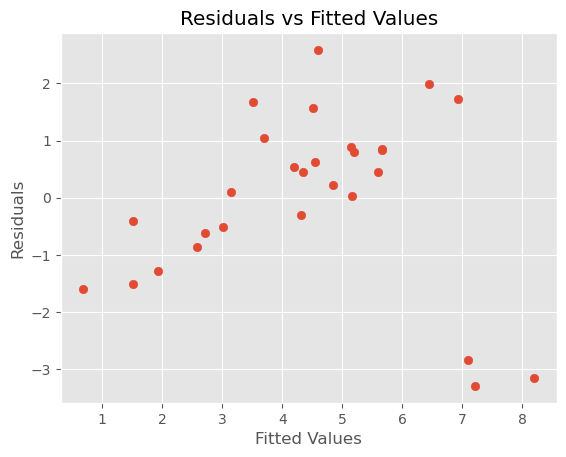

In [93]:
#Draw an histogram of the residuals and a scatter plot of residuals vs fittedvalues. Do the plots suggest a proper residual behavior?
# Draw an histogram of the residuals
plt.hist(model1_results.resid, bins=10)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

# Scatter plot of residuals vs fitted values
plt.scatter(model1_results.fittedvalues, model1_results.resid)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values')
plt.show()

Draw the regression line on the X,Y scatter plot.

/var/folders/wg/0ry_2kxj1cjg6v6gw1kzvv_40000gn/T/ipykernel_41353/3579725333.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  yy = model1_results.params[0] + model1_results.params[1] * data['log_body']


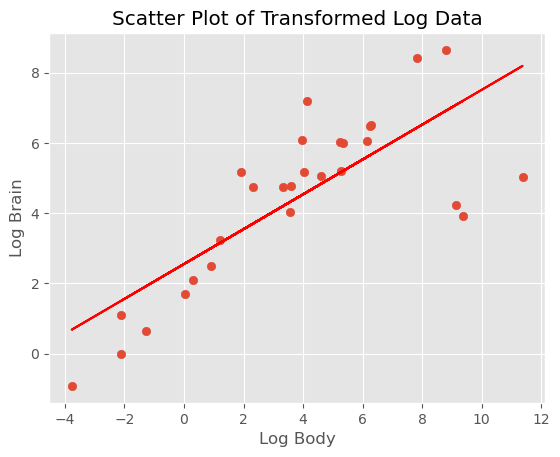

In [94]:
fig, ax = plt.subplots()
yy = model1_results.params[0] + model1_results.params[1] * data['log_body']

# Scatter plot
ax.scatter(data['log_body'], data['log_brain'])

# Set labels and title
ax.set_xlabel('Log Body')
ax.set_ylabel('Log Brain')
ax.set_title('Scatter Plot of Transformed Log Data')

# Plot the line
ax.plot(data['log_body'], yy, color='red')

# Show the plot
plt.show()


### Dummy variables

Should I treat dinosaurs independently? One can make the dataset more interesting introducing dummy variables, one for each type of dinosaurs.

Create four dummy variables: one for Triceratops, one for Dipliodocus, one for Brachiosaurus and one for dinosaur in general.


In [95]:
# Se generan las variables dummy para las tres especies de dinosaurios (outliers)
data['DummyT'] = (data.index == 'Triceratops').astype(int)
data['DummyD'] = (data.index == 'Dipliodocus').astype(int)
data['DummyB'] = (data.index == 'Brachiosaurus').astype(int)

# Se genera una variable para todos los dinosaurios sin importar cual es
data['Dinosaur'] = data[['DummyT', 'DummyD', 'DummyB']].max(axis=1)

### Regression model with dummy variables: Linear regression 2

- New model with extra predictors:

$log(brain)=\beta_0+\beta_1*log(body)+\beta_2*DummyT+\beta_3*DummyD+\beta_4*DummyB+\varepsilon$

- A different intercept if it is a dinosaur. Suppose the animal is a triceratop: the variable DummyT is equal to 1, DummyD=DummyB=0.

$\log(brain)=\beta_0+\beta_1*log(body)+\beta_2=$

$(\beta_0+\beta_2)+\beta_1*log(body)$

The intercept is $\beta_0$ when the animal is not a triceratop, while it's $\beta_0+\beta_2$ when the animal is a triceratop.

With this model we consider three different intercepts for the three dinosaurs.



In [96]:
# Crea el modelo de regresión utilizando log(body), DummyT, DummyD y DummyB como variables predictoras.
X = data[['log_body', 'DummyT', 'DummyD', 'DummyB']]
X = sm.add_constant(X)  # Add the intercept term
y = data['log_brain']

# Se hace el ajuste el modelo
model2_threeDinosaurInterceptLinearRegression = sm.OLS(y, X)
model2_results = model2_threeDinosaurInterceptLinearRegression.fit()

# Ahora se imprime el resumen del modelo
print(model2_results.summary())


                            OLS Regression Results                            
Dep. Variable:              log_brain   R-squared:                       0.922
Model:                            OLS   Adj. R-squared:                  0.908
Method:                 Least Squares   F-statistic:                     68.00
Date:                Fri, 30 Aug 2024   Prob (F-statistic):           2.10e-12
Time:                        19:32:18   Log-Likelihood:                -28.004
No. Observations:                  28   AIC:                             66.01
Df Residuals:                      23   BIC:                             72.67
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.1504      0.201     10.720      0.0

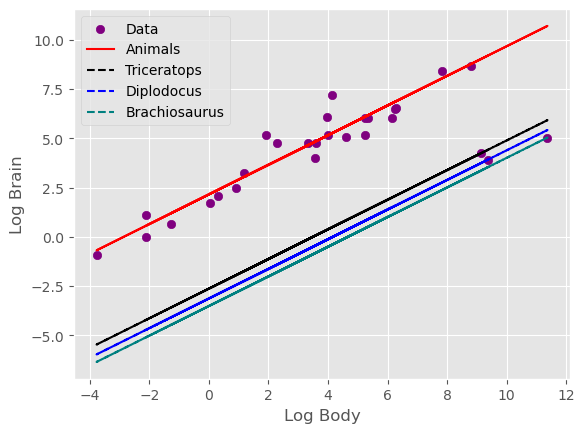

In [112]:
# Realiza un gráfico de dispersión con los datos transformados logarítmicamente.
plt.scatter(data['log_body'], data['log_brain'], color='purple', label='Data')

# Traza la línea de regresión para los no dinosaurios
pred_non_dinosaurs = model2_results.params['const'] + model2_results.params['log_body'] * data['log_body']
plt.plot(data['log_body'], pred_non_dinosaurs, color='red', label='Animals')

# Traza la línea de regresión para el Triceratops
pred_triceratops = (model2_results.params['const'] + model2_results.params['DummyT']) + model2_results.params['log_body'] * data['log_body']
plt.plot(data['log_body'], pred_triceratops, color='black', linestyle='--', label='Triceratops')

# Traza la línea de regresión para el Diplodocus
pred_diplodocus = (model2_results.params['const'] + model2_results.params['DummyD']) + model2_results.params['log_body'] * data['log_body']
plt.plot(data['log_body'], pred_diplodocus, color='blue', linestyle='--', label='Diplodocus')

# Traza la línea de regresión para el Brachiosaurus
pred_brachiosaurus = (model2_results.params['const'] + model2_results.params['DummyB']) + model2_results.params['log_body'] * data['log_body']
plt.plot(data['log_body'], pred_brachiosaurus, color='teal', linestyle='--', label='Brachiosaurus')

# Añade etiquetas y un título
plt.xlabel('Log Body')
plt.ylabel('Log Brain')
plt.legend()
plt.show()


In [98]:
# Ejemplo de predicción: Peso corporal logarítmico de 4, y es un Triceratops
log_body_value = 7
is_triceratops = 0
is_diplodocus = 0
is_brachiosaurus = 1

# Crea los valores de los predictores
predicted_log_brain = (model2_results.params['const'] + 
                       model2_results.params['log_body'] * log_body_value + 
                       model2_results.params['DummyT'] * is_triceratops + 
                       model2_results.params['DummyD'] * is_diplodocus + 
                       model2_results.params['DummyB'] * is_brachiosaurus)

print(f'Predicted log brain weight: {predicted_log_brain}')


Predicted log brain weight: 1.7500589519928482


### Annotations:
En este ejemplo, con un valor de log body de 7 y siendo un brachiosaurus dió como resultado que el peso del cerebro logarítmico será de aproximadamente 1.75. Comparándolo con el punto de intersección de la linea de este dinosaurio con el eje x, podemos notar que si hace sentido este resultado y que la predicción puede seguramente ser correcta. 

### Linear regression 3

- Model 2: same rate of change, but different intercept for dinasaurs

 $log(brain)=\beta_0+\beta_1*log(body)+\beta_2*Dino+\varepsilon$

 For an animal different from a dinosaur, the intercept is $\beta_0$. For a dinosaur the intercept is $\beta_0+\beta_2$.




In [99]:
# Crea el modelo de regresión utilizando log(body) y Dinosaurio como predictores
X3 = data[['log_body', 'Dinosaur']]
X3 = sm.add_constant(X3)  # Add the intercept term
y = data['log_brain']

# Se realiza el ajuste del modelo
model3_separateDinosaurInterceptLinearRegression = sm.OLS(y, X3)
model3_results = model3_separateDinosaurInterceptLinearRegression.fit()

# Imprime el resumen del modelo de regresión
print(model3_results.summary())


                            OLS Regression Results                            
Dep. Variable:              log_brain   R-squared:                       0.920
Model:                            OLS   Adj. R-squared:                  0.913
Method:                 Least Squares   F-statistic:                     142.9
Date:                Fri, 30 Aug 2024   Prob (F-statistic):           2.09e-14
Time:                        19:32:19   Log-Likelihood:                -28.446
No. Observations:                  28   AIC:                             62.89
Df Residuals:                      25   BIC:                             66.89
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.1616      0.195     11.090      0.0

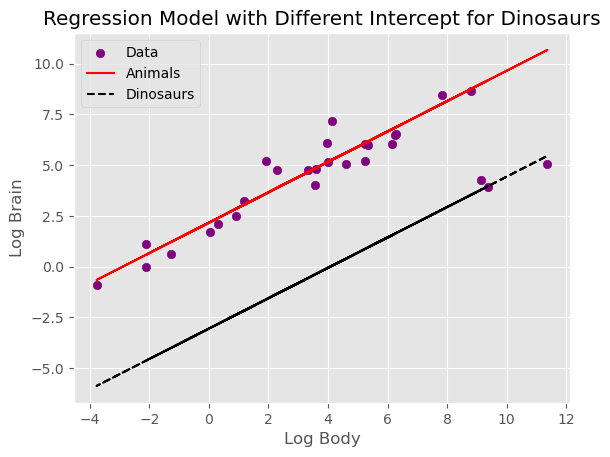

In [111]:
# Realiza un gráfico de dispersión con los datos transformados logarítmicamente
plt.scatter(data['log_body'], data['log_brain'], color='purple', label='Data')

# Traza la línea de regresión para los no dinosaurios
pred_non_dinosaurs = model3_results.params['const'] + model3_results.params['log_body'] * data['log_body']
plt.plot(data['log_body'], pred_non_dinosaurs, color='red', label='Animals')

# Traza la línea de regresión para los dinosaurios
pred_dinosaurs = (model3_results.params['const'] + model3_results.params['Dinosaur']) + model3_results.params['log_body'] * data['log_body']
plt.plot(data['log_body'], pred_dinosaurs, color='black', linestyle='--', label='Dinosaurs')

# Añade etiquetas y un título
plt.xlabel('Log Body')
plt.ylabel('Log Brain')
plt.title('Regression Model with Different Intercept for Dinosaurs')
plt.legend()
plt.show()


In [101]:
# Ejemplo de predicción: Peso corporal logarítmico de 4, y es un dinosaurio.
log_body_value = 6
is_dinosaur = 1  # Set to 1 for dinosaurs, 0 for non-dinosaurs

# Crea los valores de los predictores
predicted_log_brain_dino = (model3_results.params['const'] + 
                            model3_results.params['log_body'] * log_body_value + 
                            model3_results.params['Dinosaur'] * is_dinosaur)

print(f'Predicted log brain weight for a dinosaur: {predicted_log_brain_dino}')


Predicted log brain weight for a dinosaur: 1.43360579830461


### Annotations:
En esta predicción se toma en cuenta que el valor de log body es de 6, y que si se trata de un dinosaurio, por lo que el peso cerebral logarítmico será de 1.43 aproximadamente. Si comparamos este resultado con la intersección entre el eje del valor de log body (x) y la linea que indica la presencia de al menos un dinosaurio, podemos notar que el resultado hace sentido y por lo tanto, seguramente la predicción es correcta.

 ### Linear regression 4

 Different intercept and slope for dinosaurs. We add the feature where we multiply the variables "Dino" and "log(body)".

 $log(brain)=\beta_0+\beta_1*log(body)+\beta_2*Dino+\beta_3*log(body)*Dino+\varepsilon$

For an animal other than a dinosaur, the intercept is $\beta_0$ and the slope $\beta_1$. For a dinosaur, the intercept is $\beta_0+\beta_2$ and the slope is $\beta_1+\beta_3$.

In [102]:
# Crea el término de interacción: log_body * Dinosaurio
data['log_body_Dinosaur'] = data['log_body'] * data['Dinosaur']

# Crea el modelo de regresión utilizando log(body), Dinosaurio y el término de interacción como predictores
X_interaction = data[['log_body', 'Dinosaur', 'log_body_Dinosaur']]
X_interaction = sm.add_constant(X_interaction)  # Add the intercept term
y = data['log_brain']

# Ajusta el modelo
model4_dinosaurSlopeAndInterceptLinearRegression = sm.OLS(y, X_interaction)
model4_results = model4_dinosaurSlopeAndInterceptLinearRegression.fit()

# Imprime el resumen del modelo de regresión
print(model4_results.summary())


                            OLS Regression Results                            
Dep. Variable:              log_brain   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.912
Method:                 Least Squares   F-statistic:                     93.82
Date:                Fri, 30 Aug 2024   Prob (F-statistic):           2.15e-13
Time:                        19:32:19   Log-Likelihood:                -28.113
No. Observations:                  28   AIC:                             64.23
Df Residuals:                      24   BIC:                             69.55
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 2.1504      0.19

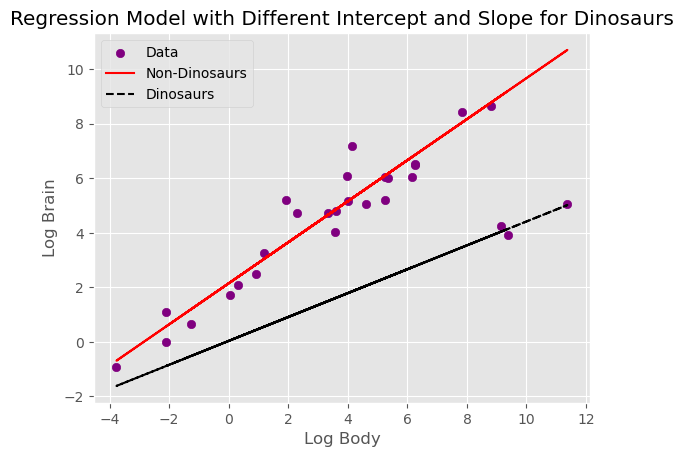

In [110]:
# Realiza un gráfico de dispersión con los datos transformados logarítmicamente
plt.scatter(data['log_body'], data['log_brain'], color='purple', label='Data')

# Traza la línea de regresión para los no dinosaurios
pred_non_dinosaurs = model4_results.params['const'] + model4_results.params['log_body'] * data['log_body']
plt.plot(data['log_body'], pred_non_dinosaurs, color='red', label='Non-Dinosaurs')

# Traza la línea de regresión para los dinosaurios
pred_dinosaurs = (model4_results.params['const'] + model4_results.params['Dinosaur']) + \
                 (model4_results.params['log_body'] + model4_results.params['log_body_Dinosaur']) * data['log_body']
plt.plot(data['log_body'], pred_dinosaurs, color='black', linestyle='--', label='Dinosaurs')

# Añade etiquetas y un título.
plt.xlabel('Log Body')
plt.ylabel('Log Brain')
plt.title('Regression Model with Different Intercept and Slope for Dinosaurs')
plt.legend()
plt.show()


In [113]:
# Ejemplo de predicción: Peso corporal logarítmico de 10, y se trata de un dinosaurio
log_body_value = 10
is_dinosaur = 1  # Se da un valor de 1 en caso de que haya dinosaurios, y 0 si no los hay

# Genera los valores de los predictores
predicted_log_brain_interaction = (model4_results.params['const'] + 
                                   model4_results.params['log_body'] * log_body_value + 
                                   model4_results.params['Dinosaur'] * is_dinosaur + 
                                   model4_results.params['log_body_Dinosaur'] * log_body_value * is_dinosaur)

print(f'Predicted log brain weight with interaction: {predicted_log_brain_interaction}')


Predicted log brain weight with interaction: 4.416369070270955


### Annotations:
En esta predicción, se considera que el valor de log body es de 10 y que si se trata de un dinosaurio, por lo que el peso cerebral logarítmico será de 4.4. Si se compara con lo obtenido en la gráfica, podemos notar que igualmente la predicción seguramente es correcta. 

Which is the best model?

In [105]:
# Decide which model is the best
#Model 1: R-squared = 0.608, Adj. R-squared = 0.593
#Model 2: R-squared = 0.922, Adj. R-squared = 0.908
#Model 3: R-squared = 0.920, Adj. R-squared = 0.913
#Model 4: R-squared = 0.921, Adj. R-squared = 0.912

Como se puede notar, los valores de R-squared y Adj. R-squared de los modelos 3 y 4 son bastante parecidos, así que como criterio de desempate tomaremos el P value. Este valor representa el efecto que tiene la variable correspondiente con la variable dependiente, por lo tanto entre mayor sea el P value, menor impacto tiene. Esto no es deseable debido a que no hay confianza que despues de tener en cuenta el resto del modelo, esa variable no contribuye significativamente a la variabilidad de la variable dependiente.

Es por esto por lo que podemos notar que el modelo 4 tiene un P value de 0.613, mientras que en el modelo 3 el valor es 0. Así que se puede concluir que el mejor modelo es el número 3.

In [117]:
#Peso corporal y del cerebro reales
peso_corporal_prediccion = 20
peso_real_cerebro = 85.4

#Transformación logarítmica de los valores
log_peso_corporal_prediccion = np.log(peso_corporal_prediccion)
datos_prediccion = pd.DataFrame({
    'const' : 1,
    'log_body' : [log_peso_corporal_prediccion],
    'Dinosaur' : [0]
})

#Hacer la predicción con un intervalo de confianza del 95%
prediccion = model3_results.get_prediction(datos_prediccion)
resumen_prediccion = prediccion.summary_frame(alpha=0.05)

print('El peso del cerebro de un animal de 20 kilos predicho en el 95% del intervalo de confianza es: ')

#Transformación exponencial para obtener el peso real del cerebro
print(f'Lower bound: {np.exp(resumen_prediccion["mean_ci_lower"].values[0])} g')
print(f'Upper bound: {np.exp(resumen_prediccion["mean_ci_upper"].values[0])} g')

#Se imprime el peso real del cerebro
print("Peso real del cerebro: 85.4 g")

El peso del cerebro de un animal de 20 kilos predicho en el 95% del intervalo de confianza es: 
Lower bound: 61.115370672767035 g
Upper bound: 109.44756561536407 g
Peso real del cerebro: 85.4 g


El modelo 3 predijo que el peso del cerebro para un animal de 20 kilos que no es un dinosaurio se encuentra entre 61.1 g y 109.4 g. El valor real es de 85.4 g, por lo que se puede concluir que el modelo realiza predicciones correctamente.